In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
import cv2

### Importing data

In [2]:
'''
from google.colab import drive

drive.mount('/content/drive')

base_path = '/content/drive/My Drive/CS441/project/data/'
ann_path = base_path + 'annotations/'
img_path = base_path + 'images/'
'''

base_path = 'data/'
ann_path = base_path + 'annotations/'
img_path = base_path + 'images/'

In [3]:
image_path = Path(img_path + 'road0.png')
if image_path.is_file():
    print(f"File exists: {image_path}")
else:
    print(f"File not found: {image_path}")

File exists: data/images/road0.png


In [4]:
def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, _, files in os.walk(root) for f in files if f.endswith(file_type)]

#extracts bounding box coordinates from an array
def create_bb_array_from_xml(root):
    #Extract bounding box from XML root
    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)
    return np.array([ymin, xmin, ymax, xmax], dtype=int)

#Loads an image from the specified path and converts it from
#BGR color format to RGB format
def read_image(path):
    image = cv2.imread(str(path))
    if image is not None:
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        print(f"Warning: Image not found at {path}")
        return None

#creates a binary mask for the area of an image defined by the bounding box.
#the mask has the same dimensions as the image with pixels inside the bounding box set to 1 and all other pixels set to 0.
def create_mask(bb, x):
    rows, cols, *_ = x.shape
    Y = np.zeros((rows, cols), dtype=float)
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

#converts a mask back into bounding box coordinates
def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0:
        return np.zeros(4, dtype=float)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=float)

#Reads an image from read_path, resizes it along with its corresponding bounding box to new dimensions based on sz
# saves the resized image to write_path.
def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    if im is None:
        return None, None  # Handle missing images
    im_resized = cv2.resize(im, (int(1.49 * sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49 * sz), sz))
    new_path = str(write_path / Path(read_path).name)
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)


In [5]:
def get_df(ann_path, img_path, train_path_resized, sz=300):
    """Create a DataFrame from annotations and images."""
    ann_path_list = get_file_list(ann_path, '.xml')
    data_list = []
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        original_path = img_path + root.find("./filename").text
        bb = create_bb_array_from_xml(root)
        new_path, new_bb = resize_image_bb(original_path, train_path_resized, bb, sz)
        if new_path:  # Ensure image was processed successfully
            data = {
                'path': new_path,
                'new_bb': new_bb,
                'class': root.find("./object/name").text
            }
            data_list.append(data)
    return pd.DataFrame(data_list)




path_resized = Path('data/images_resized')
path_resized.mkdir(exist_ok=True)
df_full = get_df(ann_path, img_path, path_resized)

In [6]:
print(len(df_full))

877


In [7]:
def prepare_and_process_data(df, size):
    X = []
    y = []

    for idx, row in df.iterrows():
        img_path = row['path']
        img_bbox = row['new_bb']
        label = row['class']

        try:
            # Read and process the image
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = Image.fromarray(img)
                image_cropped = image.crop((img_bbox[1], img_bbox[0], img_bbox[3], img_bbox[2]))

                # Convert to grayscale, resize, and flatten
                img_gray = cv2.cvtColor(np.array(image_cropped), cv2.COLOR_RGB2GRAY)
                img_resized = cv2.resize(img_gray, size)
                img_flattened = img_resized.flatten()

                X.append(img_flattened)
                y.append(label)
            else:
                print(f"Warning: Image not found at {img_path}")
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    return np.array(X), np.array(y)

In [8]:
from sklearn.model_selection import train_test_split
sz = 128
image_size = (sz, sz)

x, y = prepare_and_process_data(df_full, image_size)

# x = df_full[['path', 'new_bb']]  #stack features
# y = df_full['class']  #labels

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=34, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=34, stratify=y_temp)

print(len(x_train))

613


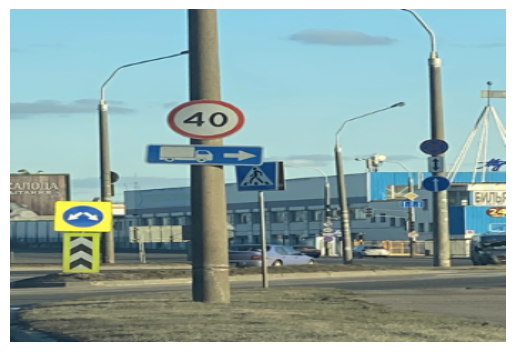

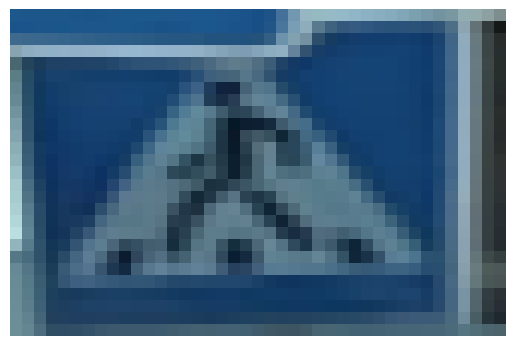

In [9]:
from PIL import Image

if not df_full.empty and 'path' in df_full.columns:
  img_path = df_full.iloc[60]['path']  # change the number to see others
  img_bbox = df_full.iloc[60]['new_bb']
  image = Image.open(img_path)
  image_cropped = image.crop((img_bbox[1], img_bbox[0], img_bbox[3], img_bbox[2])) #xmin, ymin, xmax, ymax

  plt.imshow(image)
  plt.axis('off')
  plt.show()

  plt.imshow(image_cropped)
  plt.axis('off')
  plt.show()
else:
  print("No images found in DataFrame or 'path' column missing.")

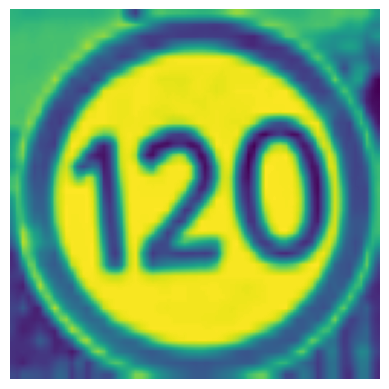

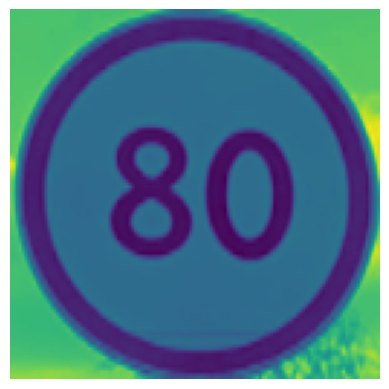

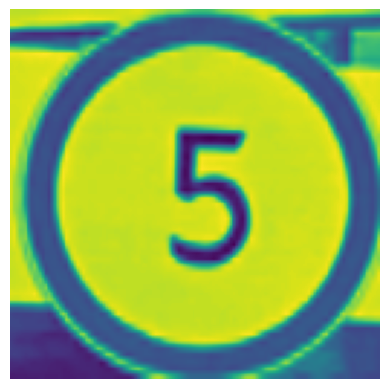

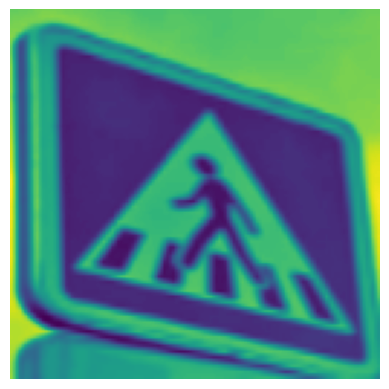

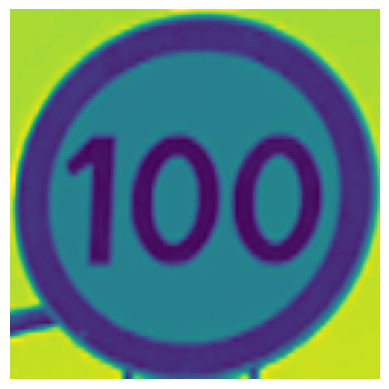

In [10]:
def display_image(arr, size=(sz, sz)):

    image = arr.reshape(size)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


for i in range(5):  # Adjust the range to display more or fewer images
    display_image(x_train[i])

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_val_pca = pca.transform(x_val)

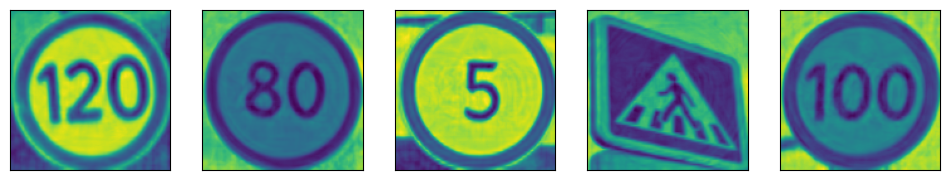

In [12]:
def reconstruct_images(pca, transformed_data, n_images, size=(sz, sz)):
    reconstructed = pca.inverse_transform(transformed_data[:n_images])
    fig, axes = plt.subplots(1, n_images, figsize=(12, 3))
    for i, ax in enumerate(axes.flat):
        ax.imshow(reconstructed[i].reshape(size))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

reconstruct_images(pca, x_train_pca, 5)

### LLR

In [33]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

N_values = [400, 450, 500, 550, 600]

errors_llr = []
val_errors_llr = []

for N in N_values:
    llr = LogisticRegression(max_iter=100000)
    llr.fit(x_train_pca[:N], y_train[:N])

    y_pred_llr = llr.predict(x_test_pca)
    error_llr = 1 - accuracy_score(y_test, y_pred_llr)
    errors_llr.append(error_llr)

    y_pred_val = llr.predict(x_val_pca)
    val_error = 1 - accuracy_score(y_val, y_pred_val)

    print(f"Trained LLR with N={N}")
    val_errors_llr.append(val_error)


for N, test_error, val_error in zip(N_values, errors_llr, val_errors_llr):
    print(f"N={N}: Test Error={test_error:.4f}, Validation Error={val_error:.4f}")

# for N, error in zip(N_values, errors_llr):
#     print(f"LLR Error for N={N}: {error:.4f}")

Trained LLR with N=400
Trained LLR with N=450
Trained LLR with N=500
Trained LLR with N=550
Trained LLR with N=600
N=400: Test Error=0.0606, Validation Error=0.0606
N=450: Test Error=0.0682, Validation Error=0.0606
N=500: Test Error=0.0758, Validation Error=0.0682
N=550: Test Error=0.0682, Validation Error=0.0682
N=600: Test Error=0.0682, Validation Error=0.0682


In [34]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],  #solvers for small datasets and binary classification, got rid of liblinear since only for binary classification
    'penalty': ['l1', 'l2'],
    'multi_class': ['multinomial']
}

# Set up GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(max_iter=10000), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(x_train_pca, y_train)

print("Best parameters for Logistic Regression:", grid_lr.best_params_)
print("Best cross-validated accuracy:", grid_lr.best_score_)

Best parameters for Logistic Regression: {'C': 0.01, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}
Best cross-validated accuracy: 0.9412901506064241


In [41]:
x_train_val_pca = np.concatenate((x_train_pca, x_val_pca), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

llr_final = LogisticRegression(max_iter=100000, C = 0.01, penalty = 'l1', solver = 'saga', multi_class='multinomial')
llr_final.fit(x_train_val_pca, y_train_val)

#predict on the test set
y_pred_final_test = llr_final.predict(x_test_pca)

#calculate final accuracy on test set
final_test_accuracy = accuracy_score(y_test, y_pred_final_test)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Final Test Accuracy: 0.9394


### SVM

In [36]:
sz = 128
image_size = (sz, sz)

x, y = prepare_and_process_data(df_full, image_size)

# x = df_full[['path', 'new_bb']]  #stack features
# y = df_full['class']  #labels

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=34, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=34, stratify=y_temp)

In [37]:
pca = PCA(n_components = 0.95)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_val_pca = pca.transform(x_val)

In [38]:
errors_svm = []
val_errors_svm = []

for N in N_values:
    svm = LinearSVC(max_iter=100000)
    svm.fit(x_train_pca[:N], y_train[:N])

    y_pred_svm = svm.predict(x_test_pca)
    error_svm = 1 - accuracy_score(y_test, y_pred_svm)
    errors_svm.append(error_svm)

    y_pred_val = svm.predict(x_val_pca)
    error_val = 1 - accuracy_score(y_val, y_pred_val)
    val_errors_svm.append(error_val)

    print(f"Trained SVM with N={N}")

for N, test_error, val_error in zip(N_values, errors_svm, val_errors_svm):
    print(f"N={N}: Test Error={test_error:.4f}, Validation Error={val_error:.4f}")

# for N, error in zip(N_values, errors_svm):
#     print(f"SVM Error for N={N}: {error:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM with N=400


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM with N=450


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM with N=500


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM with N=550
Trained SVM with N=600
N=400: Test Error=0.1212, Validation Error=0.0985
N=450: Test Error=0.1439, Validation Error=0.1061
N=500: Test Error=0.1364, Validation Error=0.1591
N=550: Test Error=0.1591, Validation Error=0.1818
N=600: Test Error=0.0758, Validation Error=0.0758


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
from sklearn.svm import SVC

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, scoring='accuracy')
grid_svm.fit(x_train_pca, y_train)

print("Best parameters for SVM:", grid_svm.best_params_)
print("Best cross-validated accuracy:", grid_svm.best_score_)

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validated accuracy: 0.9739037718246035


In [40]:
x_train_val_pca = np.concatenate((x_train_pca, x_val_pca), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

svm_final = SVC(max_iter=100000, C = 10, gamma = 'scale', kernel = 'rbf')
svm_final.fit(x_train_val_pca, y_train_val)

#predict on the test set
y_pred_final_test = svm_final.predict(x_test_pca)

#calculate final accuracy on test set
final_test_accuracy = accuracy_score(y_test, y_pred_final_test)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")

Final Test Accuracy: 0.9621


### ResNet

In [6]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from pathlib import Path
import numpy as np

In [8]:
torch.cuda.empty_cache()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
save_dir = "/content/drive/MyDrive/CS441/project/"

cuda


In [10]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_accuracy(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0 or i == 1)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("Accuracy Plot")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def save_checkpoint(save_dir, model, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    torch.save(model.state_dict(), save_path)

def load_model(model, save_dir, save_name = 'best_model.pth'):
    save_path = os.path.join(save_dir, save_name)
    model.load_state_dict(torch.load(save_path))
    return model

In [11]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:

        # TO DO: read/understand these lines and then uncomment the code below

        images = torch.tensor(images).to(device)
        labels = torch.tensor(labels).to(device)

        # zero the gradient
        optimizer.zero_grad()

        # predict labels
        prediction = model(images)

        # compute loss
        loss = criterion(prediction, labels)

        # set text to display
        it_train.set_description(f'loss: {loss:.3f}')

        # compute gradients
        loss.backward()

        # update weights
        optimizer.step()

        # keep track of losses
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:

      # TO DO: read/understand and then uncomment these lines

      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
        output = model(images) # do not compute gradient when performing prediction
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

In [12]:
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

test_transform = transforms.Compose([
            transforms.Resize(224),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

In [13]:
from sklearn.preprocessing import LabelEncoder

all_labels = df_full['class'].unique()
encoder = LabelEncoder()
encoder.fit(all_labels)

class CustomDataset(Dataset):
  def __init__(self, features, labels, transform=None, encoder=None):
    self.features = features.reset_index(drop=True)
    self.labels = labels.reset_index(drop=True)
    self.transform = transform
    self.encoder = encoder
    if self.encoder is not None:
      # Transform labels only once and store them, assuming all labels are provided at once
      self.encoded_labels = encoder.transform(labels)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    image = self.features.iloc[index]['path']
    bbox = self.features.iloc[index]['new_bb']
    image = Image.open(image).convert('RGB')
    image = image.crop((bbox[1], bbox[0], bbox[3], bbox[2]))

    if self.transform:
      image = self.transform(image)

    label = self.encoded_labels[index]

    return image, label

In [15]:
from sklearn.model_selection import train_test_split

x = df_full[['path', 'new_bb']]  #stack features
y = df_full['class']  #labels

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=34, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=34, stratify=y_temp)

In [16]:
train_set = CustomDataset(x_train, y_train, transform=train_transform, encoder=encoder)
val_set = CustomDataset(x_val, y_val, transform=train_transform, encoder=encoder)
test_set = CustomDataset(x_test, y_test, transform=test_transform, encoder=encoder)

In [17]:
def run_experiment(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
  criterion = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    train_loss = train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer)
    #print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    scheduler.step()

  train_acc, _ = test(train_loader, model, criterion=criterion)
  val_acc, _ = test(val_loader, model, criterion=criterion)

  return train_acc, val_acc

In [18]:
def reset_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
  num_target_classes = 4
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, num_target_classes)
  if hasattr(model, 'reset_parameters'):
    model.reset_parameters()
  return model

hyperparameters = {
    'learning_rate' : [0.001, 0.0001, 0.00001],
    'batch_size': [8, 16, 32],
    'scheduler': ['stepLR', 'expLR'],
    'optimizer': ['adam', 'sgd']
}

In [19]:
from itertools import product

print(device)
results = []
best_train_acc = 0

for lr, bs, sch, opt in product(hyperparameters['learning_rate'], hyperparameters['batch_size'], hyperparameters['scheduler'], hyperparameters['optimizer']):
  model = reset_model()
  model.to(device)
  train_loader = DataLoader(dataset=train_set, batch_size=bs, shuffle=True, num_workers=2)
  val_loader = DataLoader(dataset=val_set, batch_size=bs, shuffle=False, num_workers=2)

  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  elif opt == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  if sch == 'stepLR':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
  elif sch == 'expLR':
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

  train_acc, val_acc = run_experiment(model, train_loader, val_loader, optimizer, scheduler)

  results.append({
      'lr': lr,
      'batch_size': bs,
      'scheduler': sch,
      'optimizer': opt,
      'train_acc': train_acc,
      'val_acc': val_acc
  })

Validating ...: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]

Mean Accuracy: 1.0000
Avg loss: 0.03392547257244587



Validating ...: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Mean Accuracy: 0.9848
Avg loss: 0.06510536968708039


Validating ...: 100%|██████████| 20/20 [00:04<00:00,  4.60it/s]

Mean Accuracy: 0.7439
Avg loss: 0.8072261482477188



Validating ...: 100%|██████████| 5/5 [00:00<00:00,  5.06it/s]

Mean Accuracy: 0.7424
Avg loss: 0.8313278317451477


In [20]:
best_params = max(results, key=lambda x: x['val_acc'])
print(best_params)

{'lr': 0.001, 'batch_size': 8, 'scheduler': 'stepLR', 'optimizer': 'sgd', 'train_acc': 1.0, 'val_acc': 1.0}


In [22]:
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']

trainval_loader = DataLoader(ConcatDataset([train_set, val_set]), batch_size=best_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=best_batch_size, shuffle=False, num_workers=2)

In [26]:
best_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
num_target_classes = 4

num_features = best_model.fc.in_features
best_model.fc = nn.Linear(num_features, num_target_classes)
best_model = best_model.to(device)

best_optimizer = torch.optim.SGD(best_model.parameters(), lr=best_lr, momentum=0.9)
best_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

_, test_acc = run_experiment(best_model, trainval_loader, test_loader, best_optimizer, best_scheduler)

print(f"Final Test accuracy is {str(test_acc)} \n")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training ...:   0%|          | 0/94 [00:00<?, ?it/s]<ipython-input-11-c09c2846

Mean Accuracy: 1.0000
Avg loss: 0.0013724479021549724


Validating ...: 100%|██████████| 17/17 [00:01<00:00, 11.03it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0006850125911809943
Final Test accuracy is 1.0 



## Training Data Analysis

LLR

In [13]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_val_pca = pca.transform(x_val)

In [14]:
train_sizes = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
x_train_val_pca = np.concatenate((x_train_pca, x_val_pca), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

results_llr = []

for size in train_sizes:
  if size < 1.0:
    _, x_train_sample, _, y_train_sample = train_test_split(x_train_val_pca, y_train_val, test_size=size, random_state=34, stratify=y_train_val)
  else:
    x_train_sample, y_train_sample = x_train_val_pca, y_train_val

  llr = LogisticRegression(max_iter=100000, C=0.01, penalty='l1', solver='saga', multi_class='multinomial')
  llr.fit(x_train_sample, y_train_sample)

  y_pred_test = llr.predict(x_test_pca)
  accuracy = accuracy_score(y_test, y_pred_test)

  results_llr.append(accuracy)
  print(f"Trained with {size*100:.0f}% of training data: Test Accuracy = {accuracy:.4f}")

Trained with 1% of training data: Test Accuracy = 0.5076
Trained with 5% of training data: Test Accuracy = 0.7803
Trained with 10% of training data: Test Accuracy = 0.8712
Trained with 25% of training data: Test Accuracy = 0.8788
Trained with 50% of training data: Test Accuracy = 0.9167
Trained with 75% of training data: Test Accuracy = 0.9091
Trained with 100% of training data: Test Accuracy = 0.9545


SVM

In [15]:
from sklearn.svm import SVC

pca = PCA(n_components = 0.95)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_val_pca = pca.transform(x_val)

In [16]:
train_sizes = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
x_train_val_pca = np.concatenate((x_train_pca, x_val_pca), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

results_svm = []

for size in train_sizes:
  if size < 1.0:
    _, x_train_sample, _, y_train_sample = train_test_split(x_train_val_pca, y_train_val, test_size=size, random_state=34, stratify=y_train_val)
  else:
    x_train_sample, y_train_sample = x_train_val_pca, y_train_val

  svm = SVC(max_iter=100000, C=10, gamma='scale', kernel='rbf')
  svm.fit(x_train_sample, y_train_sample)

  y_pred_test = svm.predict(x_test_pca)
  accuracy = accuracy_score(y_test, y_pred_test)

  results_svm.append(accuracy)
  print(f"Trained with {size*100:.0f}% of training data: Test Accuracy = {accuracy:.4f}")

Trained with 1% of training data: Test Accuracy = 0.7576
Trained with 5% of training data: Test Accuracy = 0.8258
Trained with 10% of training data: Test Accuracy = 0.8636
Trained with 25% of training data: Test Accuracy = 0.9167
Trained with 50% of training data: Test Accuracy = 0.9394
Trained with 75% of training data: Test Accuracy = 0.9470
Trained with 100% of training data: Test Accuracy = 0.9545


ResNet50

In [17]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
from pathlib import Path
import numpy as np

In [18]:
def train(train_loader, model, criterion, optimizer):
    """
    Train network
    :param train_loader: training dataloader
    :param model: model to be trained
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :param optimizer: optimizer for model's params (Adams or SGD)
    :return: mean training loss
    """
    model.train()
    loss_ = 0.0
    losses = []

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_train = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training ...", position = 0) # progress bar
    for i, (images, labels) in it_train:

        # TO DO: read/understand these lines and then uncomment the code below

        images = torch.tensor(images).to(device)
        labels = torch.tensor(labels).to(device)

        # zero the gradient
        optimizer.zero_grad()

        # predict labels
        prediction = model(images)

        # compute loss
        loss = criterion(prediction, labels)

        # set text to display
        it_train.set_description(f'loss: {loss:.3f}')

        # compute gradients
        loss.backward()

        # update weights
        optimizer.step()

        # keep track of losses
        losses.append(loss)

    return torch.stack(losses).mean().item()

def test(test_loader, model, criterion):
    """
    Test network.
    :param test_loader: testing dataloader
    :param model: model to be tested
    :param criterion: criterion used to calculate loss (should be CrossEntropyLoss from torch.nn)
    :return: mean_accuracy: mean accuracy of predicted labels
             test_loss: mean test loss during testing
    """
    model.eval()
    losses = []
    correct = 0
    total = 0

    # TO DO: read this documentation and then uncomment the line below; https://pypi.org/project/tqdm/
    it_test = tqdm(enumerate(test_loader), total=len(test_loader), desc="Validating ...", position = 0)
    for i, (images, labels) in it_test:

      # TO DO: read/understand and then uncomment these lines

      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():  # https://pytorch.org/docs/stable/generated/torch.no_grad.html
        output = model(images) # do not compute gradient when performing prediction
      preds = torch.argmax(output, dim=-1)
      loss = criterion(output, labels)
      losses.append(loss.item())
      correct += (preds == labels).sum().item()
      total += len(labels)

    mean_accuracy = correct / total
    test_loss = np.mean(losses)
    print('Mean Accuracy: {0:.4f}'.format(mean_accuracy))
    print('Avg loss: {}'.format(test_loss))

    return mean_accuracy, test_loss

def run_experiment(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
  criterion = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    train_loss = train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer)
    #print(f'Loss for Training on epoch {str(epoch)} is {str(train_loss)} \n')

    scheduler.step()

  train_acc, _ = test(train_loader, model, criterion=criterion)
  val_acc, _ = test(val_loader, model, criterion=criterion)

  return train_acc, val_acc

In [19]:
from sklearn.preprocessing import LabelEncoder

all_labels = df_full['class'].unique()
encoder = LabelEncoder()
encoder.fit(all_labels)

class CustomDataset(Dataset):
  def __init__(self, features, labels, transform=None, encoder=None):
    self.features = features.reset_index(drop=True)
    self.labels = labels.reset_index(drop=True)
    self.transform = transform
    self.encoder = encoder
    if self.encoder is not None:
      # Transform labels only once and store them, assuming all labels are provided at once
      self.encoded_labels = encoder.transform(labels)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    image = self.features.iloc[index]['path']
    bbox = self.features.iloc[index]['new_bb']
    image = Image.open(image).convert('RGB')
    image = image.crop((bbox[1], bbox[0], bbox[3], bbox[2]))

    if self.transform:
      image = self.transform(image)

    label = self.encoded_labels[index]

    return image, label

In [20]:
def reset_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
  num_target_classes = 4
  num_features = model.fc.in_features
  model.fc = nn.Linear(num_features, num_target_classes)
  if hasattr(model, 'reset_parameters'):
    model.reset_parameters()
  return model

train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

test_transform = transforms.Compose([
            transforms.Resize(224),  # resize to 224x224 because that's the size of ImageNet images
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std= [0.229, 0.224, 0.225]),
        ])

In [29]:
x = df_full[['path', 'new_bb']]  #stack features
y = df_full['class']  #labels
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.15, stratify=y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_sizes = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
results_resnet = []

for size in train_sizes:
  if size < 1.0:
    x_train_sample, _, y_train_sample, _ = train_test_split(x_temp, y_temp, train_size=size, stratify=y_temp)
  else:
    x_train_sample, y_train_sample = x_temp, y_temp

  train_set = CustomDataset(x_train_sample, y_train_sample, transform=train_transform, encoder=encoder)
  test_set = CustomDataset(x_test, y_test, transform=test_transform, encoder=encoder)

  train_loader = DataLoader(dataset=train_set, batch_size=8, shuffle=True, num_workers=8)
  test_loader = DataLoader(dataset=test_set, batch_size=8, shuffle=False, num_workers=8)

  model = reset_model()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  _, test_acc = run_experiment(model, train_loader, test_loader, optimizer, scheduler)

  results_resnet.append(test_acc)
  print(f"Trained with {size*100:.0f}% of training data: Test Accuracy = {test_acc:.4f}")

Using cache found in /home/exouser/.cache/torch/hub/pytorch_vision_v0.10.0
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training ...:   0%|                                                                               | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_6995/874117484.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

Mean Accuracy: 0.7143
Avg loss: 0.7286151051521301



Validating ...: 100%|███████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.02it/s]
Using cache found in /home/exouser/.cache/torch/hub/pytorch_vision_v0.10.0
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Accuracy: 0.7424
Avg loss: 0.8717035966760972
Trained with 1% of training data: Test Accuracy = 0.7424


Training ...:   0%|                                                                               | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_6995/874117484.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/tmp/ipykernel_6995/874117484.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Validating ...: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.18it/s]

Mean Accuracy: 1.0000
Avg loss: 0.16338756084442138



Validating ...: 100%|███████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.94it/s]
Using cache found in /home/exouser/.cache/torch/hub/pytorch_vision_v0.10.0
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Accuracy: 0.8788
Avg loss: 0.3576745035893777
Trained with 5% of training data: Test Accuracy = 0.8788


Training ...:   0%|                                                                              | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_6995/874117484.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/tmp/ipykernel_6995/874117484.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Validating ...: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.72it/s]

Mean Accuracy: 1.0000
Avg loss: 0.09343149792402983



Validating ...: 100%|███████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  5.94it/s]
Using cache found in /home/exouser/.cache/torch/hub/pytorch_vision_v0.10.0
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Accuracy: 0.9697
Avg loss: 0.18809600021032727
Trained with 10% of training data: Test Accuracy = 0.9697


Training ...:   0%|                                                                              | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_6995/874117484.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/tmp/ipykernel_6995/874117484.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Validating ...: 100%|███████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.20it/s]

Mean Accuracy: 1.0000
Avg loss: 0.00943903134369369



Validating ...: 100%|███████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.55it/s]
Using cache found in /home/exouser/.cache/torch/hub/pytorch_vision_v0.10.0
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Accuracy: 1.0000
Avg loss: 0.023728585856802323
Trained with 25% of training data: Test Accuracy = 1.0000


Training ...:   0%|                                                                              | 0/47 [00:00<?, ?it/s]/tmp/ipykernel_6995/874117484.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/tmp/ipykernel_6995/874117484.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Validating ...: 100%|███████████████████████████████████████████████████████████████████| 47/47 [00:09<00:00,  4.71it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0026861459668230344



Validating ...: 100%|███████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.80it/s]
Using cache found in /home/exouser/.cache/torch/hub/pytorch_vision_v0.10.0
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Accuracy: 1.0000
Avg loss: 0.011785682064809781
Trained with 50% of training data: Test Accuracy = 1.0000


Training ...:   0%|                                                                              | 0/70 [00:00<?, ?it/s]/tmp/ipykernel_6995/874117484.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/tmp/ipykernel_6995/874117484.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Validating ...: 100%|███████████████████████████████████████████████████████████████████| 70/70 [00:14<00:00,  4.81it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0016824173166761673



Validating ...: 100%|███████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.73it/s]
Using cache found in /home/exouser/.cache/torch/hub/pytorch_vision_v0.10.0
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/miniconda3/envs/train_model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Mean Accuracy: 0.9924
Avg loss: 0.014877329366487068
Trained with 75% of training data: Test Accuracy = 0.9924


Training ...:   0%|                                                                              | 0/94 [00:00<?, ?it/s]/tmp/ipykernel_6995/874117484.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
/tmp/ipykernel_6995/874117484.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Validating ...: 100%|███████████████████████████████████████████████████████████████████| 94/94 [00:20<00:00,  4.68it/s]

Mean Accuracy: 1.0000
Avg loss: 0.0023286475673925684



Validating ...: 100%|███████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.70it/s]

Mean Accuracy: 0.9924
Avg loss: 0.011406269884045125
Trained with 100% of training data: Test Accuracy = 0.9924


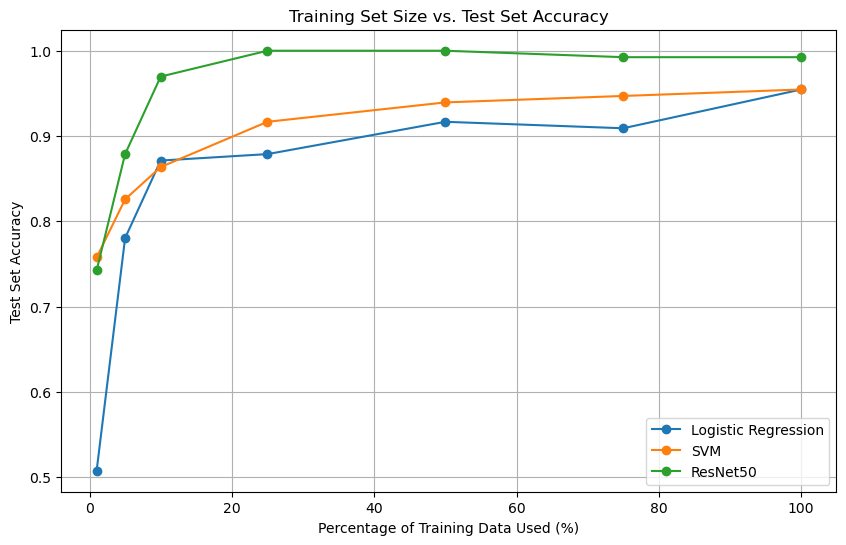

In [30]:
plt.figure(figsize=(10, 6))
plt.plot([size * 100 for size in train_sizes], results_llr, marker='o', label='Logistic Regression')
plt.plot([size * 100 for size in train_sizes], results_svm, marker='o', label='SVM')
plt.plot([size * 100 for size in train_sizes], results_resnet, marker='o', label='ResNet50')
plt.title('Training Set Size vs. Test Set Accuracy')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Test Set Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Innovation

We were able to show how LLR, SVM, and ResNet models can take an image of a road sign and correctly classify it into one of the 4 labels. But what about the other way around? Can we give a model a label and generate an image? Here we will implement a cGAN (Conditional Generative Adversial Network) for this purpose.

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder

all_labels = df_full['class'].unique()
encoder = LabelEncoder()
encoder.fit(all_labels)

label_encoding = {label: encoder.transform([label])[0] for label in encoder.classes_}

# Printing the encoding for each label
print("Label to Encoding Mapping:")
for label, encoding in label_encoding.items():
    print(f"{label}: {encoding}")

class CustomDataset(Dataset):
  def __init__(self, features, labels, transform=None, encoder=None):
    self.features = features.reset_index(drop=True)
    self.labels = labels.reset_index(drop=True)
    self.transform = transform
    self.encoder = encoder
    if self.encoder is not None:
      # Transform labels only once and store them, assuming all labels are provided at once
      self.encoded_labels = encoder.transform(labels)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    image = self.features.iloc[index]['path']
    bbox = self.features.iloc[index]['new_bb']
    image = Image.open(image).convert('RGB')
    image = image.crop((bbox[1], bbox[0], bbox[3], bbox[2]))

    if self.transform:
      image = self.transform(image)

    label = self.encoded_labels[index]

    return image, label

transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, )),
        ])

Label to Encoding Mapping:
crosswalk: 0
speedlimit: 1
stop: 2
trafficlight: 3


In [195]:
class Generator(nn.Module):
  def __init__(self, latent_dim, num_classes, img_shape, channels):
    super(Generator, self).__init__()
    self.label_embedding = nn.Embedding(num_classes, num_classes)
    self.init_size = img_shape
    self.channels = channels

    self.conv_blocks = nn.Sequential(
        nn.Linear(latent_dim + num_classes, 128),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),

        nn.Linear(128, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),

        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),

        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),

        nn.Linear(1024, channels * self.init_size * self.init_size),
        nn.Tanh()
    )

  def forward(self, noise, labels):
    labels = self.label_embedding(labels)
    gen_input = torch.cat((noise, labels), -1)
    out = self.conv_blocks(gen_input)
    out = out.reshape(out.size(0), self.channels, self.init_size, self.init_size)
    return out

class Discriminator(nn.Module):
  def __init__(self, num_classes, img_shape, channels):
    super(Discriminator, self).__init__()
    self.label_embedding = nn.Embedding(num_classes, num_classes)

    self.model = nn.Sequential(
        nn.Linear(channels * img_shape * img_shape + num_classes, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    )

  def forward(self, img, labels):
    img_flat = torch.flatten(img, 1)
    labels = self.label_embedding(labels)
    d_input = torch.cat([img_flat, labels], -1)
    out = self.model(d_input)
    return out

In [212]:
num_classes = 4
latent_dim = 124
img_shape = 64
channels = 3

generator = Generator(latent_dim=latent_dim, num_classes=num_classes, img_shape=img_shape, channels=channels)
discriminator = Discriminator(num_classes=num_classes, img_shape=img_shape, channels=channels)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.999))

adversarial_loss = nn.MSELoss()

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

features = df_full[['path', 'new_bb']]
labels = df_full['class']
dataset = CustomDataset(features, labels, transform=transform, encoder=encoder)
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=8)

In [213]:
n_epochs = 300

for epoch in range(n_epochs):
    discriminator.train()
    generator.train()
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1, device=device, requires_grad=False)
        invalid = torch.zeros(batch_size, 1, device=device, requires_grad=False)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        noise = torch.randn([batch_size, latent_dim], device=device)
        conditional = torch.randint(0, num_classes, (batch_size, ), device=device)
        
        #Train Discriminator
        optimizer_D.zero_grad()
        
        real_output = discriminator(real_imgs, labels)
        d_loss_real = adversarial_loss(real_output, valid)

        fake = generator(noise, conditional)
        fake_output = discriminator(fake.detach(), conditional)
        d_loss_fake = adversarial_loss(fake_output, invalid)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        #Train Generator
        optimizer_G.zero_grad()

        fake_output = discriminator(fake, conditional)
        g_loss = adversarial_loss(fake_output, valid)
        g_loss.backward()
        optimizer_G.step()

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [216]:
def show_image(img, ind):
    # Convert tensor to numpy array
    npimg = img.numpy()
    
    # Transpose from (channel, height, width) to (height, width, channel)
    npimg = np.transpose(npimg, (1, 2, 0))
    
    # Denormalize the image
    npimg = (npimg + 1) / 2  # Transform from [-1, 1] to [0, 1]
    npimg = np.clip(npimg, 0, 1)  # Ensure pixel values are within [0, 1]
    
    # Display the image
    plt.imshow(npimg)
    plt.title(f'Image of Class {ind}')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

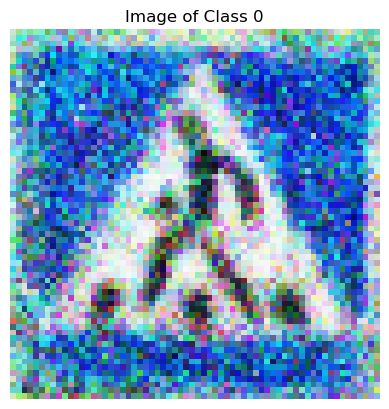

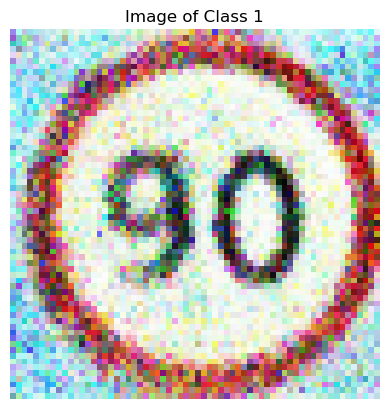

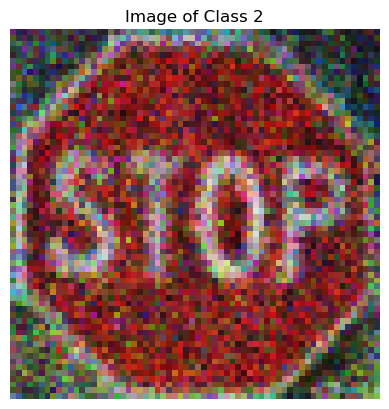

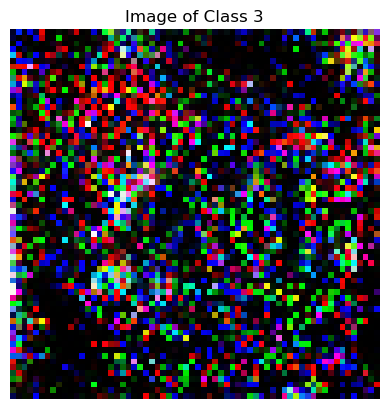

In [217]:
label_index = [0, 1, 2, 3] #0: crosswalk, 1: speedlimit, 2: stop, 3: trafficlight

latent_dim = 124
batch_size = 1

generator = Generator(latent_dim=latent_dim, num_classes=4, img_shape=64, channels=3)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

for ind in label_index:
    noise = torch.randn([batch_size, latent_dim], device=device)
    class_label = torch.tensor([ind]).to(device)
    with torch.no_grad():
        gen_image = generator(noise, class_label)
    gen_image = gen_image[0]
    show_image(gen_image, ind)